DNN识别4种不同的信号：OOK、BPSK、Unipolar-PAM4、Bipolar-PAM4

In [20]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset


In [21]:
#添加噪声
def add_awgn(signal, snr_db):
    snr = 10 ** (snr_db / 10)
    signal_power = np.mean(signal ** 2)
    noise_power = signal_power / snr
    noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
    return signal + noise

In [22]:
#生成不同4中信号
def generate_waveform(signal_type, symbol_rate,sample_rate,snr_db):
    if signal_type == 'OOK':
        signal_ook = np.random.randint(0,2, symbol_rate)
        waveform = np.repeat(signal_ook, int(sample_rate/symbol_rate))
    elif signal_type == 'BPSK':
        signal_bpsk = np.random.randint(0,2, symbol_rate) * 2 - 1
        waveform = np.repeat(signal_bpsk, int(sample_rate/symbol_rate))
    elif signal_type == 'Unipolar-PAM4':
        signal_unipolar_pam4 = np.random.randint(0,4, symbol_rate)
        waveform = np.repeat(signal_unipolar_pam4, int(sample_rate/symbol_rate))
    elif signal_type == 'Bipolar-PAM4':
        signal_bipolar_pam4 = np.random.randint(0,4, symbol_rate) * 2 - 3
        waveform = np.repeat(signal_bipolar_pam4, int(sample_rate/symbol_rate))
    else:
        raise ValueError("Unknown modulation type")
    return add_awgn(waveform,snr_db)

#one-hot 编码    
signal_type_to_label = {
    "OOK": [1,0,0,0],
    "BPSK": [0,1,0,0],
    "Unipolar-PAM4": [0,0,1,0],
    "Bipolar-PAM4": [0,0,0,1]
}

#生成数据集并转化为tensor
def generate_dataset(num_samples_per_class, signal_rate, sampling_rate,snr_db):
    dataset = []
    labels = []
    for _ in range(num_samples_per_class * 4):
        signal_type = np.random.choice(list(signal_type_to_label.keys()))
        signal = generate_waveform(signal_type, signal_rate, sampling_rate, snr_db)
        signal = torch.tensor(signal, dtype=torch.float32)
        label = torch.tensor([signal_type_to_label[signal_type]], dtype=torch.float32)
        dataset.append(signal)
        labels.append(label)

    labels = torch.cat(labels)
    dataset = torch.stack(dataset)
    return dataset, labels

tensor([[ 0.8186,  1.1109,  1.1380,  ...,  0.2780,  0.0134,  0.2220],
        [-1.3162, -0.7950, -0.8136,  ..., -1.3184, -1.0099, -0.8558],
        [-0.8523, -0.7330, -1.3332,  ...,  1.2478,  0.9742,  1.4279],
        ...,
        [ 0.9839,  0.6413,  1.4529,  ..., -1.2704, -1.2369, -1.2825],
        [-0.7590, -0.4944, -0.5208,  ..., -0.7385, -1.1539, -1.2074],
        [ 0.8554,  0.9211,  1.1513,  ..., -0.2173, -0.4025,  0.1899]])
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]])


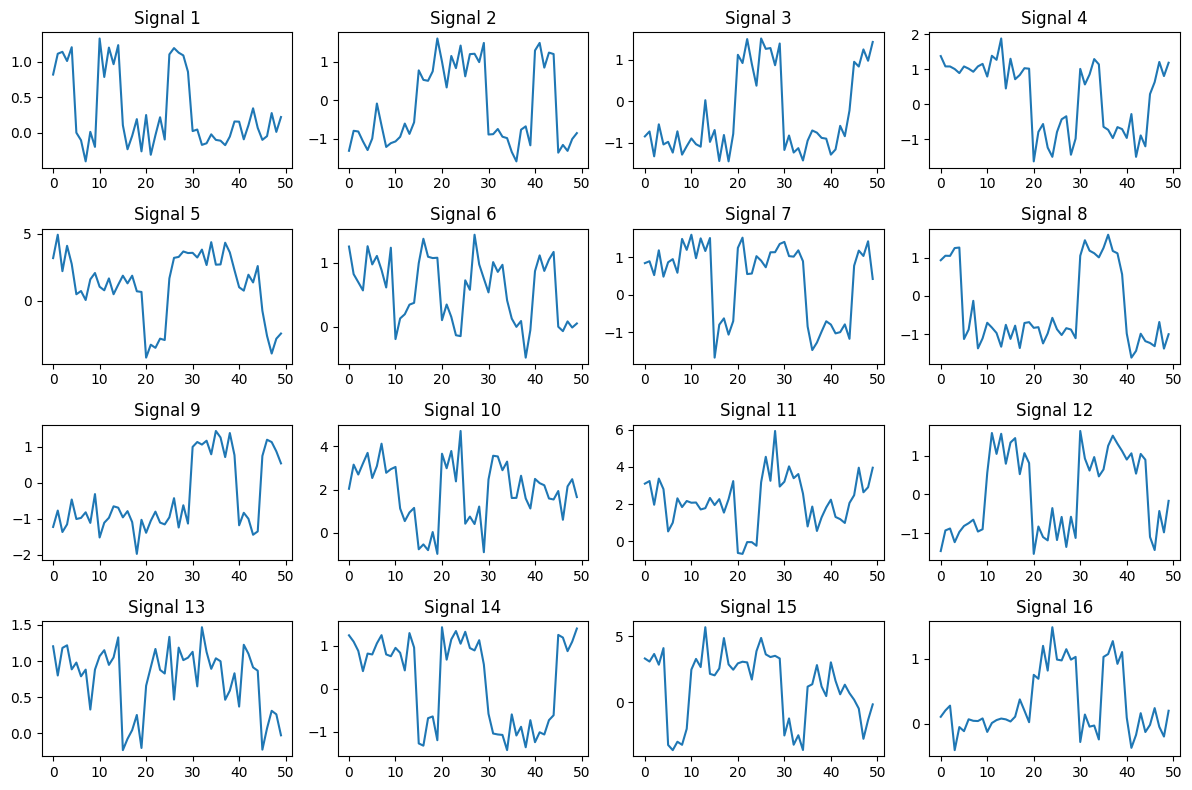

Dataset saved to 'signal_dataset.pt'


In [23]:
#生成数据集
num_samples_per_class = 100  # 示例值
signal_rate = 10  # 示例值
sampling_rate = 50  # 示例值
snr_db = 10  # 示例值
dataset, labels = generate_dataset(num_samples_per_class, signal_rate, sampling_rate, snr_db)
print(dataset)
print(labels)

 
# 保存数据集到文件
torch.save({'dataset': dataset, 'labels': labels}, 'signal_dataset.pt')
plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.plot(dataset[i].numpy())
    plt.title(f'Signal {i+1}')
plt.tight_layout()
plt.show()

print("Dataset saved to 'signal_dataset.pt'")

In [24]:
#定义DNN模块
class DNNModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.5):
        super(DNNModel, self).__init__()
        
        # 确保hidden_sizes列表长度至少为2，以支持至少两个隐藏层
        if len(hidden_sizes) < 2:
            raise ValueError("hidden_sizes list must contain at least two elements.")
        
        # 定义神经网络的各层
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])  # 第一层
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])  # 第二层
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)  # 输出层
        
        # Dropout层
        self.dropout = nn.Dropout(dropout_rate)
        
        # 激活函数
        self.relu = nn.ReLU()
 
    def forward(self, x):
        # 前向传播
        x = self.relu(self.fc1(x))  # 第一层 -> ReLU 激活
        x = self.relu(self.fc2(x))  # 第二层 -> ReLU 激活
        x = self.fc3(x)  # 输出层 (没有激活函数，因为输出是一个类别概率)
        return x

Epoch [1/1000], Loss: 1.3688
Epoch [2/1000], Loss: 1.3504
Epoch [3/1000], Loss: 1.3370
Epoch [4/1000], Loss: 1.3258
Epoch [5/1000], Loss: 1.3143
Epoch [6/1000], Loss: 1.3022
Epoch [7/1000], Loss: 1.2896
Epoch [8/1000], Loss: 1.2759
Epoch [9/1000], Loss: 1.2607
Epoch [10/1000], Loss: 1.2445
Epoch [11/1000], Loss: 1.2273
Epoch [12/1000], Loss: 1.2093
Epoch [13/1000], Loss: 1.1907
Epoch [14/1000], Loss: 1.1718
Epoch [15/1000], Loss: 1.1528
Epoch [16/1000], Loss: 1.1336
Epoch [17/1000], Loss: 1.1151
Epoch [18/1000], Loss: 1.0970
Epoch [19/1000], Loss: 1.0792
Epoch [20/1000], Loss: 1.0626
Epoch [21/1000], Loss: 1.0465
Epoch [22/1000], Loss: 1.0308
Epoch [23/1000], Loss: 1.0161
Epoch [24/1000], Loss: 1.0016
Epoch [25/1000], Loss: 0.9882
Epoch [26/1000], Loss: 0.9745
Epoch [27/1000], Loss: 0.9617
Epoch [28/1000], Loss: 0.9494
Epoch [29/1000], Loss: 0.9372
Epoch [30/1000], Loss: 0.9257
Epoch [31/1000], Loss: 0.9141
Epoch [32/1000], Loss: 0.9033
Epoch [33/1000], Loss: 0.8925
Epoch [34/1000], Lo

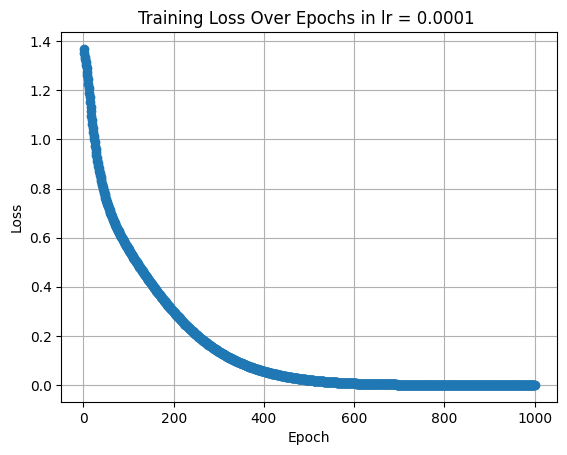

In [25]:
import time

input_size = 50
hidden_sizes = [20, 10]
output_size = 4

 
# 加载数据
loaded_data = torch.load('signal_dataset.pt')
dataset = loaded_data['dataset']
labels = loaded_data['labels']
tensor_dataset = TensorDataset(dataset.to(dtype=torch.float32), labels.to(dtype=torch.float32))  # 确保标签是长整型
train_loader = DataLoader(tensor_dataset, batch_size=10, shuffle=True)
 
training_time = []
loss_history = []

model = DNNModel(input_size, hidden_sizes, output_size,dropout_rate=0.01)
criterion = nn.CrossEntropyLoss()
start_time = time.time()

lr = 0.0001 #0.1 0.01 0.001 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()  # 切换到训练模式
    running_loss = 0.0
    for batch_dataset, batch_labels in train_loader:
        optimizer.zero_grad()  # 清空梯度
        outputs = model(batch_dataset)  # 计算模型输出
        loss = criterion(outputs, batch_labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重
        
        running_loss += loss.item()  # 累加损失
    epoch_loss = running_loss / len(train_loader)  # 计算平均损失
    loss_history.append(epoch_loss)  # 将平均损失添加到历史记录中    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
end_time = time.time()
train_time = end_time - start_time
plt.plot(range(1, num_epochs + 1), loss_history, marker='o')
plt.title(f'Training Loss Over Epochs in lr = {lr} ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"loss_gragh_{lr}.png")
print(f"Training time: {train_time:.2f} seconds")


In [26]:
# 生成测试集
def generate_dataset(num_samples_per_class, signal_rate, sampling_rate,snr_db):
    dataset = []
    labels = []
    for _ in range(num_samples_per_class * 4):
        signal_type = np.random.choice(list(signal_type_to_label.keys()))
        signal = generate_waveform(signal_type, signal_rate, sampling_rate, snr_db)
        signal = torch.tensor(signal, dtype=torch.float32)
        label = torch.tensor([signal_type_to_label[signal_type]], dtype=torch.float32)
        dataset.append(signal)
        labels.append(label)

    labels = torch.cat(labels)
    return dataset, labels

snr_array = np.arange(0,15)
num_samples_per_class = 1000  # 示例值
signal_rate = 10  # 示例值
sampling_rate = 50  # 示例值
for snr_db in snr_array:
    dataset, labels = generate_dataset(num_samples_per_class, signal_rate, sampling_rate, snr_db)
    torch.save({'dataset': dataset, 'labels': labels}, f'signal_testdata_snr = {snr_db}.pt')


Average Loss: 2.3058, Accuracy: 0.7585
Average Loss: 2.0606, Accuracy: 0.7765
Average Loss: 1.5399, Accuracy: 0.8110
Average Loss: 1.4986, Accuracy: 0.8240
Average Loss: 1.1733, Accuracy: 0.8478
Average Loss: 0.9608, Accuracy: 0.8692
Average Loss: 0.9341, Accuracy: 0.8798
Average Loss: 0.8393, Accuracy: 0.8872
Average Loss: 0.8358, Accuracy: 0.8968
Average Loss: 0.8584, Accuracy: 0.8935
Average Loss: 0.6980, Accuracy: 0.9002
Average Loss: 0.8406, Accuracy: 0.8965
Average Loss: 0.7571, Accuracy: 0.8988
Average Loss: 0.7704, Accuracy: 0.9030
Average Loss: 0.6995, Accuracy: 0.9052


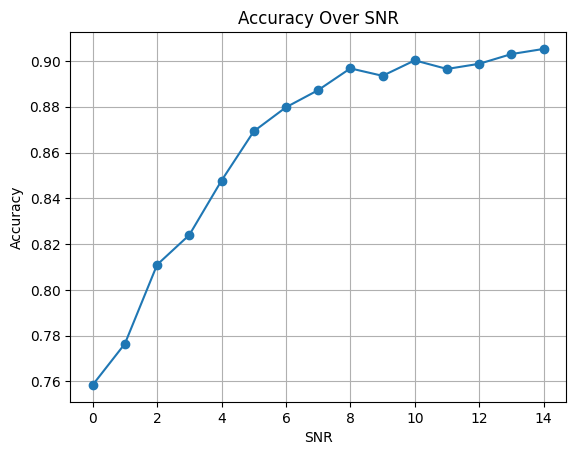

In [27]:
#验证准确率
acc = []
model.eval()
for snr_db in snr_array:
    loaded_data = torch.load(f'signal_testdata_snr = {snr_db}.pt')
    dataset = loaded_data['dataset']
    labels = loaded_data['labels']

    test_dataset = TensorDataset(torch.stack(dataset), labels.to(dtype = torch.float32))  # 确保标签是长整型
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 禁用梯度计算
    with torch.no_grad():
        total_loss = 0.0
        correct = 0
        total = 0.0
        # criterion = torch.nn.CrossEntropyLoss()
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # model.to(device)
        
        for inputs, labels in test_loader:
            # 将数据移动到正确的设备
            # inputs, labels = inputs.to(device), labels.to(device)
            
            # 前向传播
            outputs = model(inputs)
            
            # 计算损失（对于分类任务，通常使用交叉熵损失）
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)  # 累加每个batch的损失
            
            # 计算准确率
            _, predicted = torch.max(outputs, 1)
            labels = labels.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        
        # 计算平均损失和准确率
        average_loss = total_loss / total
        accuracy = correct / total
        
        print(f'Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')
    acc.append(accuracy)


plt.plot(range(0, 15), acc, marker='o')
plt.title('Accuracy Over SNR')
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig("Accuracy_Over_SNR.png")